# Lab Four: Multi-Layer Perceptron

Ephraim Sun (7324)
Jadon Swearingen (5324)
Adeeb Abdul Taher (7324)

Lab Assignment Four: Multi-Layer Perceptron 
In this lab, you will compare the performance of multi-layer perceptron programmed  via your own various implementations. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. This lab project is slightly different from other reports in that you will be asked to complete more specific items.

Dataset Selection

For this assignment, you will be using a specific dataset chosen by the instructor.  This is US Census data available on Kaggle, and also downloadable from the following link: https://www.dropbox.com/s/bf7i7qjftk7cmzq/acs2017_census_tract_data.csv?dl=0Links to an external site.

The Kaggle description appears here: https://www.kaggle.com/muonneutrino/us-census-demographic-data/dataLinks to an external site. 

The classification task you will be performing is to predict, for each tract, what the child poverty rate will be. You will need to convert this from regression to four levels of classification by quantizing the variable of interest. 

Grading Rubric

### Load, Split, and Balance (1.5 points total)
[.5 points] 
- (1) Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric. 
- (2) Remove any observations that having missing data. 
- (3) Encode any string data as integers for now. 
- (4) You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('./acs2017_census_tract_data.csv')

df.head()

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_51484/2151317996.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


### Visualizing the data

We dropped any observations with missing data. Based on the df.shape and the df.dtypes, it seems to us that there are not a lot of null values and we encoded all the strings data as integers as well.

In [2]:
# part two 
print(df.shape)
df.dropna(inplace=True)
df.shape
#not too many missing

(74001, 37)


(72718, 37)

In [3]:
df.dtypes

TractId               int64
State                object
County               object
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          

In [4]:
print(len(df.State.unique()))
print(len(df.County.unique()))

52
1954


### Dropped County Field
We have decided to drop the "County" field because we believe that in this datasets, it makes more sense to keep the laws, ordinances, and decrees on a state level compared to the county level, since most counties are not different from each other in each state. In addition, the County Field is a lot more specific to the State Field, making it harder for us to encode and the significance of County is much smaller.

In [5]:
df.drop('County',axis=1,inplace=True)

In [6]:
df.dtypes

TractId               int64
State                object
TotalPop              int64
Men                   int64
Women                 int64
Hispanic            float64
White               float64
Black               float64
Native              float64
Asian               float64
Pacific             float64
VotingAgeCitizen      int64
Income              float64
IncomeErr           float64
IncomePerCap        float64
IncomePerCapErr     float64
Poverty             float64
ChildPoverty        float64
Professional        float64
Service             float64
Office              float64
Construction        float64
Production          float64
Drive               float64
Carpool             float64
Transit             float64
Walk                float64
OtherTransp         float64
WorkAtHome          float64
MeanCommute         float64
Employed              int64
PrivateWork         float64
PublicWork          float64
SelfEmployed        float64
FamilyWork          float64
Unemployment        

In [7]:
# Encode State data into integer value
initial_list = df.State.unique()
codes = {initial_list[i]: i for i in range(len(initial_list))}

df = df.replace(codes)

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_51484/3968205504.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(codes)


In [8]:
uniqueChildPovertyValues = len(df['ChildPoverty'].unique())
quartileInstances = int(len(df)/4)

print(f'There are {uniqueChildPovertyValues} different ChildPoverty values')
print(f'We want ~{quartileInstances} instances in each class to create somewhat equal quartiles')
def categorise(row):  
    if row['ChildPoverty'] > 0 and row['ChildPoverty'] <= 8:
        return 'fourth_quartile'
    elif row['ChildPoverty'] > 8 and row['ChildPoverty'] <= 19:
        return 'third_quartile'
    elif row['ChildPoverty'] > 19  and row['ChildPoverty'] <= 37:
        return 'second_quartile'
    return 'first_quartile'

df['poverty_quartile'] = df.apply(lambda row: categorise(row), axis=1)

print(df['poverty_quartile'].value_counts())

There are 954 different ChildPoverty values
We want ~18179 instances in each class to create somewhat equal quartiles
poverty_quartile
first_quartile     18699
second_quartile    18583
third_quartile     18306
fourth_quartile    17130
Name: count, dtype: int64


Above, we balanced the dataset so that about the same number of instances are within each class. The method chosen here is to divide the "ChildPoverty" variable into quartiles and assign each data point to one of the quartiles. This is achieved by defining thresholds based on quartile ranges and then categorizing each data point accordingly. By doing so, it ensures that approximately the same number of instances are within each quartile, thus balancing the dataset.


Balancing the dataset is should not be done the testing set but on the training set. This is because the goal of balancing is to ensure that the model learns from a representative distribution of the data during training. Balancing the testing set could introduce bias and make the evaluation results less reliable. Thus, we want to balance the training set but not the testing in order to maintain the integrity of the evaluation process.

In [9]:
y = df['poverty_quartile']
#one hot encode the poverty quartile
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['poverty_quartile', 'ChildPoverty']), y, test_size=0.20, random_state=1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(58174, 35)
(58174, 4)
(14544, 35)
(14544, 4)


### Pre-processing and Initial Modeling (2.5 points total)
You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: 
- (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). It is recommended to use sigmoids throughout the network, but not required.

- [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

- [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

- [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs. 

- [1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.  

Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.



#### Overivew of two layer network with Vectorized Gradient Computation, Mini-batching, Cross Entopy Loss, and Glorot Initialization

The two-layer perceptron implementation includes the following enhancements: vectorized gradient computation, mini-batching, cross-entropy loss, and proper Glorot initialization. More information can be found on how these enhancements help make it efficient and effective for training on large datasets for classification tasks.

- Vectorized Gradient Computation: The _get_gradient method in TwoLayerPerceptronVectorized and its subclasses (TLPVectorizedMiniBatch and TLPVectorizedMiniBatchCrossEntropyGlorot) implements vectorized backpropagation for efficient computation of gradients.

- Mini-Batching: The TLPVectorizedMiniBatch class implements mini-batch gradient descent by splitting the dataset into smaller batches and updating weights iteratively using these mini-batches. It allows for faster training and efficient memory usage.

- Cross Entropy Loss: The TLPVectorizedMiniBatchCrossEntropyGlorot class uses cross-entropy loss as the cost function (_cost method). Cross-entropy loss is a common choice for classification tasks, especially when dealing with binary or multiclass classification problems.

- Proper Glorot Initialization: The TLPVectorizedMiniBatchCrossEntropyGlorot class also includes Glorot initialization for weight initialization (_initialize_weights method). Glorot initialization helps in stabilizing the training process and improving convergence by setting appropriate initial values for the weights.



In [10]:
#Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
#Original Author: Sebastian Raschka

import numpy as np
from scipy.special import expit
import sys
import pandas as pd

# start with a simple base classifier, which can't be fit or predicted
# it only has internal classes to be used by classes that will subclass it
# Start with the following functions:
#    init
#    encode_labels
#    initialize weights
#    sigmoid
#    add bias (vector of ones)
#    objective function (cost and regularizer)
class TwoLayerPerceptronBase(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        
    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation"""
        onehot = pd.get_dummies(y).values.T
            
        return onehot

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W
        
        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2
    
    @staticmethod
    def _sigmoid(z):
        """Use scipy.special.expit to avoid overflow"""
        # 1.0 / (1.0 + np.exp(-z))
        return expit(z)
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _L2_reg(lambda_, W1, W2):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2))
    
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        cost = np.mean((Y_enc-A3)**2)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
# now let's add in the following functions:
#    feedforward
#    fit and predict
class TwoLayerPerceptron(TwoLayerPerceptronBase):
    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs 

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        return A1, Z1, A2, Z2, A3
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # need to vectorize this computation!
        # See additional code and derivation below!
    
    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred
    
    
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.cost_ = []
        for i in range(self.epochs):

            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)
            
            cost = self._cost(A3,Y_enc,self.W1,self.W2)
            self.cost_.append(cost)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y_enc=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2
            

        return self
class TwoLayerPerceptronVectorized(TwoLayerPerceptron):
    # just need a different gradient calculation
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = -2*(Y_enc-A3)*A3*(1-A3)
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka
# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.
class TLPVectorizedMiniBatch(TwoLayerPerceptronVectorized):
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, **kwds):        
        # need to add to the original initializer 
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
        
        
        # but keep other keywords
        super().__init__(**kwds)

    def fit(self, X, y, print_progress=0):
        """ Learn weights from training data."""
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_data, y_data = X.copy().values, y.copy()
        else:
            X_data, y_data = X.copy(), y.copy()

        Y_enc = self._encode_labels(y)
        
        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2 = self._initialize_weights()
        
        # start momentum at zero for previous updates
        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):

            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!

            if print_progress>0 and (k+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (k+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]

            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            for idx in mini:

                # feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_data[idx],
                                                       self.W1,
                                                       self.W2)
                
                cost = self._cost(A3,Y_enc[:, idx],self.W1,self.W2)
                mini_cost.append(cost) # this appends cost of mini-batch only

                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2,
                                                  Y_enc=Y_enc[:, idx],
                                                  W1=self.W1, W2=self.W2)

                rho_W1, rho_W2 = eta * grad1, eta * grad2
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                rho_W1_prev, rho_W2_prev = rho_W1, rho_W2

            self.cost_.append(mini_cost)
            
        return self



class TLPVectorizedMiniBatchCrossEntropyGlorot(TLPVectorizedMiniBatch):
    """Uses Initialize Weights"""
    

    def _initialize_weights(self):
        """Initialize weights Glorot and He normalization."""
        init_bound = 4*np.sqrt(6. / (self.n_hidden + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden + 1)) 
        W2[:,:1] = 0
        
        return W1, W2
    
    
    """Cost function that uses cross entropy"""
    def _cost(self,A3,Y_enc,W1,W2):
        '''Get the objective function value'''
        # cost = -np.mean(np.nan_to_num((Y_enc*np.log(A3)+(1-Y_enc)*np.log(1-A3))))
        # L2_term = self._L2_reg(self.l2_C, W1, W2)
        
        eps = 1e-7
        A3 = np.clip(A3, eps, 1 - eps)
        cost = -np.mean(Y_enc * np.log(A3 + eps) + (1 - Y_enc) * np.log(1 - A3 + eps))
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term
    
    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """ Compute gradient step using backpropagation.
        """
        # vectorized backpropagation
        V2 = (A3-Y_enc) # <- this is only line that changed
        V1 = A2*(1-A2)*(W2.T @ V2)
        
        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T
        
        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C

        return grad1, grad2
    

In [11]:
# Function to convert data into format to test accuracy with
def convert_data(y_pred):
  returnMe = pd.DataFrame()
  
  returnMe['first_quartile'] = (y_pred == 0)
  returnMe['second_quartile'] = (y_pred == 1)
  returnMe['third_quartile'] = (y_pred == 2)
  returnMe['fourth_quartile'] = (y_pred == 3)

  return returnMe

#### Model Implementation without Normalization or One-Hot Encoding

Epoch: 500/500

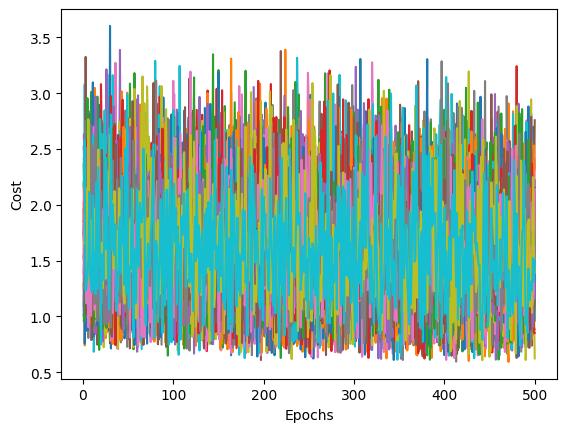

Accuracy: 0.25673817381738173


In [12]:
# train the model
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score

params = { 'n_hidden':30, 
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = TLPVectorizedMiniBatchCrossEntropyGlorot(**params)
model.fit(X_train, y_train, print_progress=True)
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Model Implementation with Normalization

Epoch: 500/500

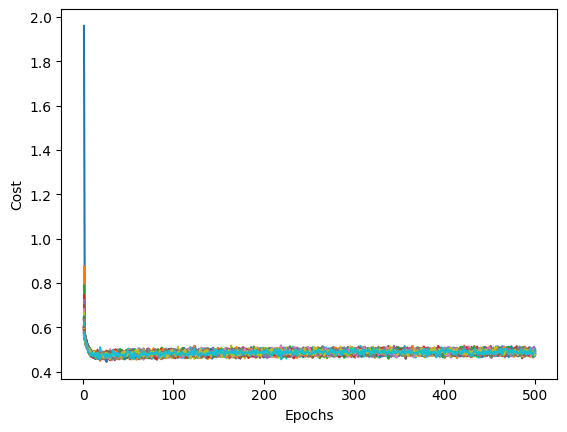

Accuracy: 0.7007013201320133


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# define the TwoLayerPerceptron and TwoLayerPerceptronBase classes here

class NormalizedTwoLayerPerceptron(TLPVectorizedMiniBatchCrossEntropyGlorot):
    def fit(self, X, y, print_progress=False):
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        super().fit(X_norm, y, print_progress=print_progress)
        self.scaler_ = scaler
        
    def predict(self, X):
        X_norm = self.scaler_.transform(X)
        return super().predict(X_norm)

# train the model
params = { 'n_hidden':30, 
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = NormalizedTwoLayerPerceptron(n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=42)
model = NormalizedTwoLayerPerceptron(**params)
model.fit(X_train, y_train, print_progress=True)

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


#### Model Implementation with Normalization and One-Hot Encoding

In [14]:
y = df['poverty_quartile']
y = pd.get_dummies(y)

X_categorical = df[['State']]
X = df.drop(['poverty_quartile', 'ChildPoverty', 'State'], axis=1)

# Normalize the numeric feature data
X_norm = StandardScaler().fit_transform(X)

# One-hot encode the categorical features
X_categorical = pd.get_dummies(X_categorical)

# Concatenate the numeric and categorical features
X = np.concatenate((X_norm, X_categorical), axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)


Epoch: 500/500

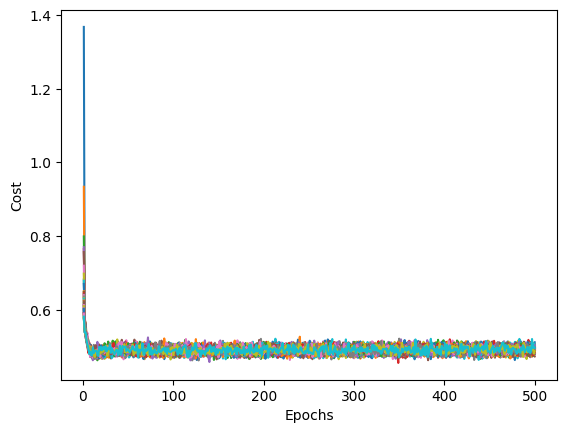

Accuracy: 0.7040704070407041


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# train the model
params = { 'n_hidden':30, 
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = NormalizedTwoLayerPerceptron(n_hidden=30, C=0.0, epochs=500, eta=0.001, random_state=42)
model = NormalizedTwoLayerPerceptron(**params)
model.fit(X_train, y_train, print_progress=True)

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


### Comparing performance


#### First Model
- The frst model achieved an accuracy score of approximately 25.67% without applying any form of normalization or one-hot encoding to the input data. Thus, certain columns exhibited disproportionately higher influence on the model's predictions, leading to substantial disparities in accuracy when compared to subsequent models.


#### Second Model
- The second model acheived an accuracy score of approximately 70.07%. This improvement was due to the introduction of normalization techniques, mitigating biases arising from uneven feature scales.


#### Third Model
- The third model further acheived an accuracy score of approximately 70.41%. The marginal improvement observed in this model was due to the incorporation of one-hot encoding for the "state" column. This exemplifies the pivotal role played by one-hot encoding in enhancing the representational capacity of the model. It is worth noting that while the improvement in accuracy was moderate in this instance, the significance of one-hot encoding becomes increasingly pronounced when dealing with a larger number of unencoded columns.

# Modeling (5 points total)
[1 points] Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.

Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

[1 points] Repeat the previous step, adding support for a fourth layer.

[1 points] Repeat the previous step, adding support for a fifth layer. 

[2 points] Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the 
performance of your five layer model with and without the adaptive learning strategy. Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.


#### Three Layer Perceptron

In [16]:
class ThreeLayerPerceptron(NormalizedTwoLayerPerceptron):
    
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, n_hidden_1=30, n_hidden_2=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):  
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.grad_avg_ = []  # Add this line

        #I just copy pasted all of the init functions so I can see what it is doing better
        

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        #added another block, changed it to use the new number of hidden before finally n_output
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1 + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1 + 1)) 
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_2 + 1)) 
        W3[:,:1] = 0
        
        return W1, W2, W3

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2))

    def _cost(self, A4, Y_enc, W1, W2, W3):
        '''Get the objective function value'''
        #just need to add W3 to the L2_term for three layer
        eps = 1e-7
        A4 = np.clip(A4, eps, 1 - eps)
        cost = -np.mean(Y_enc * np.log(A4 + eps) + (1 - Y_enc) * np.log(1 - A4 + eps))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    def _feedforward(self, X, W1, W2, W3):
        """Compute feedforward step"""
        ##just added the Z3 and A4 calculations (copy paste)
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4

    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """ Compute gradient step using backpropagation. """
        #had to change it to make three gradients
         # vectorized backpropagation
        V3 = (A4 - Y_enc)
        V2 = A3 * (1 - A3) * (W3.T @ V3)
        # V1 = A2 * (1 - A2) * (W2.T @ V2)
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])

        grad3 = V3 @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C

        return grad1, grad2, grad3

    def predict(self, X):
        """Predict class labels"""
        #added the transform from "normalized" two layer, also added W3
        X_norm = self.scaler_.transform(X)
        _, _, _, _, _, _, A4 = self._feedforward(X_norm, self.W1, self.W2, self.W3)
        y_pred = np.argmax(A4, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        self.scaler_ = scaler
        
        
        #I had to just change anything that had a 2 to also have a 3 basically
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_data, y_data = X.copy().values, y.copy()
        else:
            X_data, y_data = X.copy(), y.copy()

        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):
            
            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!
            
            
            if print_progress > 0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k + 1, self.epochs))
                sys.stderr.flush()
                
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
                
            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad_avg = []  # Temporary list for this epoch's gradients

            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3)

                cost = self._cost(A4, Y_enc[:,idx], self.W1, self.W2, self.W3)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                grad1, grad2, grad3 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4, Z1=Z1, Z2=Z2, Z3=Z3, Y_enc=Y_enc[:,idx],
                                                        W1=self.W1, W2=self.W2, W3=self.W3)
                # Compute the average magnitude of the gradients and append it to self.grad_avg_
                grad_avg = (np.mean(np.abs(grad1)) + np.mean(np.abs(grad2)) + np.mean(np.abs(grad3))) / 3
                mini_grad_avg.append(grad_avg)
                rho_W1, rho_W2,rho_W3 = eta * grad1, eta * grad2,eta * grad3
                # Save average gradient magnitudes
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
            self.grad_avg_.append(np.mean(mini_grad_avg))
            self.cost_.append(mini_cost)
    def plot_grad_avg(self):
        """Plot the average gradient magnitudes."""
        plt.plot(range(len(self.grad_avg_)), self.grad_avg_)
        plt.xlabel('Epoch')
        plt.ylabel('Average Gradient Magnitude')
        plt.show()
        return self

Epoch: 500/500

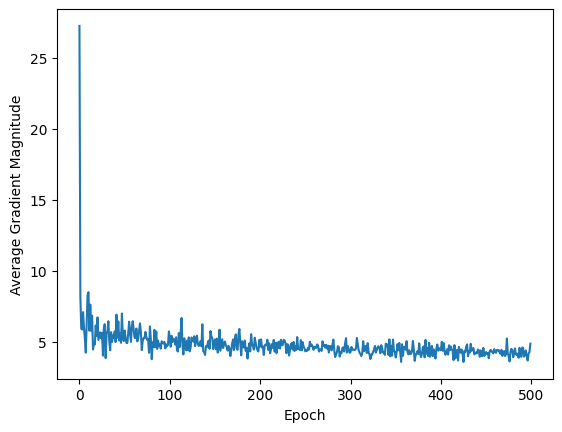

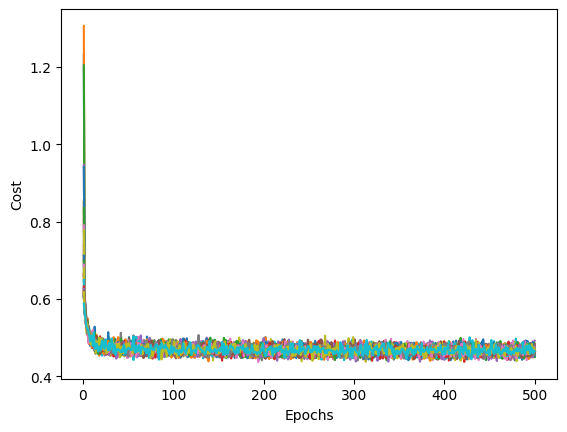

Accuracy: 0.7026952695269527


In [17]:
params = { 'n_hidden_1':30,'n_hidden_2':30, 
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = ThreeLayerPerceptron(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Four Layer Perceptron

In [18]:

class FourLayerPerceptron(ThreeLayerPerceptron):
    
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, n_hidden_1=30, n_hidden_2=30,n_hidden_3=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):  
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.grad_avg_ = []  # Add this line

        #I just copy pasted all of the init functions so I can see what it is doing better
        

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        #added another block, changed it to use the new number of hidden before finally n_output
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1 + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1 + 1)) 
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_3 + 1)) 
        W4[:,:1] = 0
        
        return W1, W2, W3, W4

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2))

    def _cost(self, A5, Y_enc, W1, W2, W3, W4):
        '''Get the objective function value'''
        #just need to add W3 to the L2_term for three layer
        eps = 1e-7
        A5 = np.clip(A5, eps, 1 - eps)
        cost = -np.mean(Y_enc * np.log(A5 + eps) + (1 - Y_enc) * np.log(1 - A5 + eps))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4)
        return cost + L2_term
    def _feedforward(self, X, W1, W2, W3, W4):
        """Compute feedforward step"""
        ##just added the Z3 and A4 calculations (copy paste)
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')

        Z4 = W4 @ A4
        A5 = self._sigmoid(Z4)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5

    def _get_gradient(self, A1, A2, A3, A4, A5, Z1, Z2, Z3, Z4, Y_enc, W1, W2, W3, W4):
        """ Compute gradient step using backpropagation. """
        #had to change it to make three gradients
         # vectorized backpropagation
        V4 = (A5 - Y_enc)
        V3 = A4 * (1 - A4) * (W4.T @ V4)
        V2 = A3 * (1 - A3) * (W3.T @ V3[1:, :])
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])
        # V1 = A2 * (1 - A2) * (W2.T @ V2)

        grad4 = V4 @ A4.T
        grad3 = V3[1:, :] @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4

    def predict(self, X):
        """Predict class labels"""
        #added the transform from "normalized" two layer, also added W3
        X_norm = self.scaler_.transform(X)
        #A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5
        _, _, _, _, _, _, _, _, A5 = self._feedforward(X_norm, self.W1, self.W2, self.W3, self.W4)
        y_pred = np.argmax(A5, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        self.scaler_ = scaler
        
        
        #I had to just change anything that had a 2 to also have a 3 basically
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_data, y_data = X.copy().values, y.copy()
        else:
            X_data, y_data = X.copy(), y.copy()

        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):
            
            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!
            
            
            if print_progress > 0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k + 1, self.epochs))
                sys.stderr.flush()
                
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
                
            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad_avg = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.W4)

                cost = self._cost(A5, Y_enc[:,idx], self.W1, self.W2, self.W3, self.W4)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4,A5=A5, Z1=Z1, Z2=Z2, Z3=Z3,Z4=Z4, Y_enc=Y_enc[:,idx],
                                                        W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4)                # Compute the average magnitude of the gradients and append it to self.grad_avg_
                grad_avg = (np.mean(np.abs(grad1)) + np.mean(np.abs(grad2)) + np.mean(np.abs(grad4)) + np.mean(np.abs(grad3))) / 4
                mini_grad_avg.append(grad_avg)

                
                rho_W1, rho_W2,rho_W3,rho_W4 = eta * grad1, eta * grad2,eta * grad3, eta * grad4
                # Save average gradient magnitudes
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
            self.grad_avg_.append(np.mean(mini_grad_avg))
            self.cost_.append(mini_cost)

        return self

Epoch: 500/500

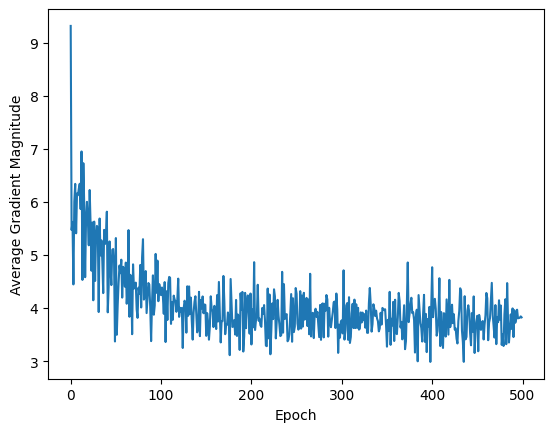

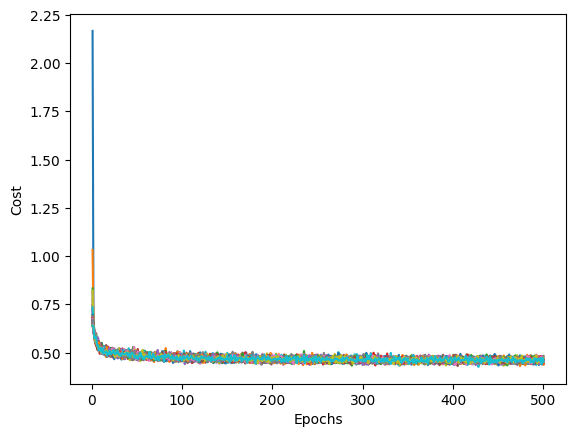

Accuracy: 0.6965071507150715


In [19]:

params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FourLayerPerceptron(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Five Layer Perceptron

In [20]:

class FiveLayerPerceptron(FourLayerPerceptron):
    
    def __init__(self, alpha=0.1, decrease_const=0.0, shuffle=True, minibatches=1, n_hidden_1=30, n_hidden_2=30,n_hidden_3=30,n_hidden_4=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):  
        np.random.seed(random_state)
        self.n_hidden_1 = n_hidden_1
        self.n_hidden_2 = n_hidden_2
        self.n_hidden_3 = n_hidden_3
        self.n_hidden_4 = n_hidden_4
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.grad_avg_ = []  # Add this line

        #I just copy pasted all of the init functions so I can see what it is doing better
        

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        #added another block, changed it to use the new number of hidden before finally n_output
        init_bound = 4*np.sqrt(6. / (self.n_hidden_1 + self.n_features_ + 1))
        W1 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_1, self.n_features_ + 1))
        W1[:,:1] = 0
        
        # reduce the final layer magnitude in order to balance the size of the gradients
        # between 
        init_bound = 4*np.sqrt(6 / (self.n_hidden_2 + self.n_hidden_1 + 1))
        W2 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_2, self.n_hidden_1 + 1)) 
        W2[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_3 + self.n_hidden_2 + 1))
        W3 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_3, self.n_hidden_2 + 1)) 
        W3[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_hidden_4 + self.n_hidden_3 + 1))
        W4 = np.random.uniform(-init_bound, init_bound,(self.n_hidden_4, self.n_hidden_3 + 1)) 
        W4[:,:1] = 0
        
        init_bound = 4*np.sqrt(6 / (self.n_output_ + self.n_hidden_4 + 1))
        W5 = np.random.uniform(-init_bound, init_bound,(self.n_output_, self.n_hidden_4 + 1)) 
        W5[:,:1] = 0
        
        return W1, W2, W3, W4, W5

    @staticmethod
    def _L2_reg(lambda_, W1, W2, W3, W4, W5):
        """Compute L2-regularization cost"""
        # only compute for non-bias terms
        return (lambda_) * np.sqrt(np.mean(W1[:, 1:] ** 2) + np.mean(W2[:, 1:] ** 2) + np.mean(W3[:, 1:] ** 2) + np.mean(W4[:, 1:] ** 2) + np.mean(W5[:, 1:] ** 2))

    def _cost(self, A6, Y_enc, W1, W2, W3, W4, W5):
        '''Get the objective function value'''
        #just need to add W3 to the L2_term for three layer
        eps = 1e-7
        A6 = np.clip(A6, eps, 1 - eps)
        cost = -np.mean(Y_enc * np.log(A6 + eps) + (1 - Y_enc) * np.log(1 - A6 + eps))
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3, W4, W5)
        return cost + L2_term
    def _feedforward(self, X, W1, W2, W3, W4, W5):
        """Compute feedforward step"""
        ##just added the Z3 and A4 calculations (copy paste)
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3, how='row')
        Z3 = W3 @ A3
        A4 = self._sigmoid(Z3)
        A4 = self._add_bias_unit(A4, how='row')
        Z4 = W4 @ A4
        
        A5 = self._sigmoid(Z4)
        A5 = self._add_bias_unit(A5, how='row')
        Z5 = W5 @ A5
        
        A6 = self._sigmoid(Z5)
        return A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6

    def _get_gradient(self, A1, A2, A3, A4, A5, A6, Z1, Z2, Z3, Z4, Z5, Y_enc, W1, W2, W3, W4, W5):
        """ Compute gradient step using backpropagation. """
        #had to change it to make three gradients
         # vectorized backpropagation
        V5 = (A6 - Y_enc)
        V4 = A5 * (1 - A5) * (W5.T @ V5)
        V3 = A4 * (1 - A4) * (W4.T @ V4[1:, :])
        V2 = A3 * (1 - A3) * (W3.T @ V3[1:, :])
        V1 = A2 * (1 - A2) * (W2.T @ V2[1:, :])
        # V1 = A2 * (1 - A2) * (W2.T @ V2)

        grad5 = V5 @ A5.T
        grad4 = V4[1:, :] @ A4.T
        grad3 = V3[1:, :] @ A3.T
        grad2 = V2[1:, :] @ A2.T
        grad1 = V1[1:, :] @ A1.T

        # regularize weights that are not bias terms
        grad1[:, 1:] += W1[:, 1:] * self.l2_C
        grad2[:, 1:] += W2[:, 1:] * self.l2_C
        grad3[:, 1:] += W3[:, 1:] * self.l2_C
        grad4[:, 1:] += W4[:, 1:] * self.l2_C
        grad5[:, 1:] += W5[:, 1:] * self.l2_C

        return grad1, grad2, grad3, grad4, grad5

    def predict(self, X):
        """Predict class labels"""
        #added the transform from "normalized" two layer, also added W3
        X_norm = self.scaler_.transform(X)
        #A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6
        _, _, _, _, _, _, _, _, _, _,A6 = self._feedforward(X_norm, self.W1, self.W2, self.W3, self.W4, self.W5)
        y_pred = np.argmax(A6, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        self.scaler_ = scaler
        
        
        #I had to just change anything that had a 2 to also have a 3 basically
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_data, y_data = X.copy().values, y.copy()
        else:
            X_data, y_data = X.copy(), y.copy()

        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum
        rho_W5_prev = np.zeros(self.W5.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):
            
            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!
            
            
            if print_progress > 0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k + 1, self.epochs))
                sys.stderr.flush()
                
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
                
            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad_avg = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.W4, self.W5)

                cost = self._cost(A6, Y_enc[:,idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4,A5=A5,A6=A6, Z1=Z1, Z2=Z2, Z3=Z3,Z4=Z4,Z5=Z5, Y_enc=Y_enc[:,idx],
                                                        W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4,W5=self.W5)
                                # compute gradient via backpropagation
              # Compute the average magnitude of the gradients and append it to self.grad_avg_
                grad_avg = (np.mean(np.abs(grad1)) + np.mean(np.abs(grad2)) + np.mean(np.abs(grad4)) + np.mean(np.abs(grad5)) + np.mean(np.abs(grad3))) / 5
                mini_grad_avg.append(grad_avg)

                rho_W1, rho_W2,rho_W3,rho_W4,rho_W5 = eta * grad1, eta * grad2,eta * grad3, eta * grad4, eta * grad5
                # Save average gradient magnitudes
                self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum
            self.grad_avg_.append(np.mean(mini_grad_avg))
            self.cost_.append(mini_cost)

        return self

Epoch: 500/500

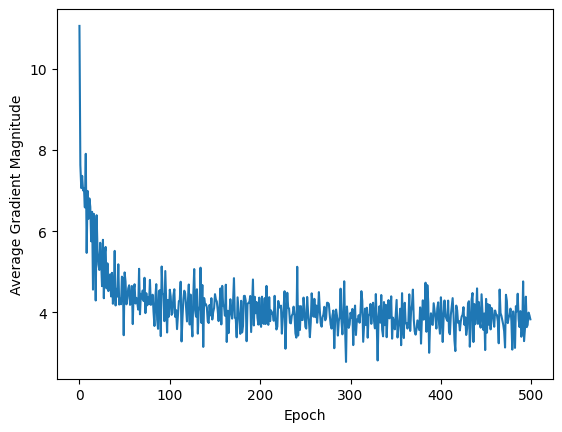

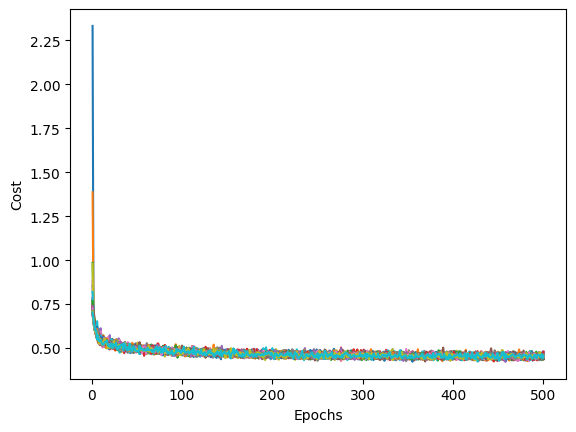

Accuracy: 0.7044829482948295


In [21]:

params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,'n_hidden_4':30,
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FiveLayerPerceptron(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Layer Perceptron Differences


- 2nd layer: 70.407%
- 3rd layer: 70.27%
- 4th layer: 69.65%
- 5th layer: 70.45%

Based on our model results, this shows that adding more layers to our perceptron network doesn't necessarily mean that it does better, as showcased in the 4th layer. However, based on finetuning the parameters, we can achieved a better result like thr 5th layer of 70.45%.

If the hyperparameters are tuned correctly, the model accuracy could be significantly better.


# RMS Prop Adaptive Learning Technique

We decided to use RMSProp as our learning technique on our five layer peceptron network. RMSProp adapts the learning rate for each parameter individually based on the magnitude of recent gradients. It contains a decay rate that determines accumulated squared gradients and epsilon, which prevent division by zero and ensure numerical stability during optimization. In addition, RMSProp is a efficient optimization that is simple to implement.

We choose RMSProp over AdaDelta not only because we are more familiarized with RMSProp but also because RMSProp occasionally outperforms AdaDelta in terms of convergence speed and final performance.


In [22]:

class FiveLayerPerceptronRMSProp(FiveLayerPerceptron):
    def __init__(self, decay_rate=0.9, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.decay_rate = decay_rate
        self.eps = eps
        self.sq_grad1 = 0
        self.sq_grad2 = 0
        self.sq_grad3 = 0
        self.sq_grad4 = 0
        self.sq_grad5 = 0
        self.grad_avg_ = []
    
    def _update_weights(self, grad1, grad2, grad3, grad4, grad5):
        # Update the weights using RMSProp
        self.sq_grad1 = self.decay_rate * self.sq_grad1 + (1 - self.decay_rate) * grad1**2
        self.sq_grad2 = self.decay_rate * self.sq_grad2 + (1 - self.decay_rate) * grad2**2
        self.sq_grad3 = self.decay_rate * self.sq_grad3 + (1 - self.decay_rate) * grad3**2
        self.sq_grad4 = self.decay_rate * self.sq_grad4 + (1 - self.decay_rate) * grad4**2
        self.sq_grad5 = self.decay_rate * self.sq_grad5 + (1 - self.decay_rate) * grad5**2

        self.W1 -= (self.eta / np.sqrt(self.sq_grad1 + self.eps)) * grad1
        self.W2 -= (self.eta / np.sqrt(self.sq_grad2 + self.eps)) * grad2
        self.W3 -= (self.eta / np.sqrt(self.sq_grad3 + self.eps)) * grad3
        self.W4 -= (self.eta / np.sqrt(self.sq_grad4 + self.eps)) * grad4
        self.W5 -= (self.eta / np.sqrt(self.sq_grad5 + self.eps)) * grad5
        
    def fit(self, X, y, print_progress=False):
        """ Learn weights from training data."""
        scaler = StandardScaler()
        X_norm = scaler.fit_transform(X)
        self.scaler_ = scaler
        
        
        #I had to just change anything that had a 2 to also have a 3 basically
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X_data, y_data = X.copy().values, y.copy()
        else:
            X_data, y_data = X.copy(), y.copy()

        Y_enc = self._encode_labels(y)

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = Y_enc.shape[0]
        self.W1, self.W2, self.W3, self.W4, self.W5 = self._initialize_weights()

        rho_W1_prev = np.zeros(self.W1.shape) # for momentum
        rho_W2_prev = np.zeros(self.W2.shape) # for momentum
        rho_W3_prev = np.zeros(self.W3.shape) # for momentum
        rho_W4_prev = np.zeros(self.W4.shape) # for momentum
        rho_W5_prev = np.zeros(self.W5.shape) # for momentum

        self.cost_ = []
        for k in range(self.epochs):
            
            # adaptive learning rate
            eta = self.eta**(1+self.decrease_const*k)# decreasing learning rate
            eta = max(eta,self.eta/1000)
            # there are many forms of adaptive learning rates out there!
            
            
            if print_progress > 0 and (k + 1) % print_progress == 0:
                sys.stderr.write('\rEpoch: %d/%d' % (k + 1, self.epochs))
                sys.stderr.flush()
                
                
            if self.shuffle:
                ridx = np.random.permutation(y_data.shape[0])
                X_data, Y_enc = X_data[ridx], Y_enc[:, ridx]
                
                
            # use numpy split to split into equal sized batches 
            # num batches== self.minibatches
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            mini_cost = []
            mini_grad_avg = []
            for idx in mini:
                # feedforward all instances
                A1, Z1, A2, Z2, A3, Z3, A4, Z4, A5, Z5, A6 = self._feedforward(X_data[idx], self.W1, self.W2, self.W3, self.W4, self.W5)

                cost = self._cost(A6, Y_enc[:,idx], self.W1, self.W2, self.W3, self.W4, self.W5)
                mini_cost.append(cost)

                # compute gradient via backpropagation
                grad1, grad2, grad3, grad4, grad5 = self._get_gradient(A1=A1, A2=A2, A3=A3, A4=A4,A5=A5,A6=A6, Z1=Z1, Z2=Z2, Z3=Z3,Z4=Z4,Z5=Z5, Y_enc=Y_enc[:,idx],
                                                        W1=self.W1, W2=self.W2, W3=self.W3, W4=self.W4,W5=self.W5)
                grad_avg = (np.mean(np.abs(grad1)) + np.mean(np.abs(grad2)) + np.mean(np.abs(grad3))) / 3

                mini_grad_avg.append(grad_avg)
                #no longer using mometum, using RMS Prop instead
                # rho_W1, rho_W2,rho_W3,rho_W4,rho_W5 = eta * grad1, eta * grad2,eta * grad3, eta * grad4, eta * grad5
                # # Save average gradient magnitudes
                # self.W1 -= (rho_W1 + (self.alpha * rho_W1_prev)) # update with momentum
                # self.W2 -= (rho_W2 + (self.alpha * rho_W2_prev)) # update with momentum
                # self.W3 -= (rho_W3 + (self.alpha * rho_W3_prev)) # update with momentum
                # self.W4 -= (rho_W4 + (self.alpha * rho_W4_prev)) # update with momentum
                # self.W5 -= (rho_W5 + (self.alpha * rho_W5_prev)) # update with momentum
                
                self._update_weights(grad1, grad2, grad3, grad4, grad5)
            self.grad_avg_.append(np.mean(mini_grad_avg))
            self.cost_.append(mini_cost)

        return self

Epoch: 500/500

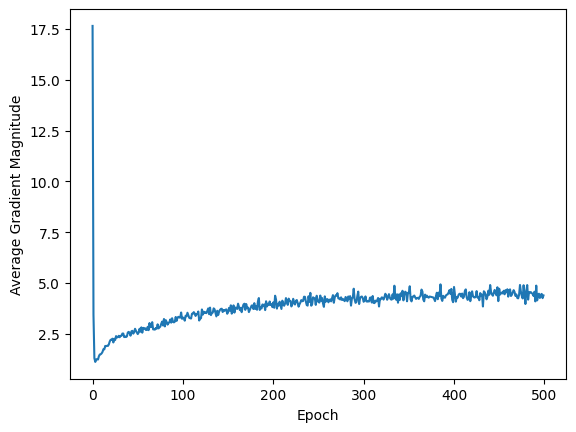

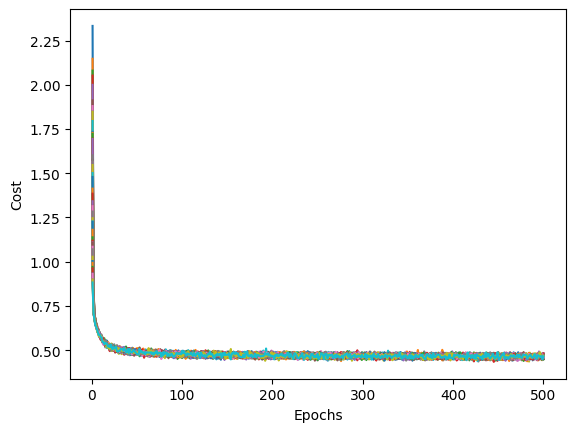

Accuracy: 0.7087458745874587


In [23]:

params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,'n_hidden_4':30,
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FiveLayerPerceptronRMSProp(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

### Comparison Result of RMSProp


The fifth layer perceptron without the RMSProp obtained an accuracy of 70.45% while with the RMSProp it contained a accuracy a few points higher with an accuracy of 70.87%. This is because the RMSProp adapts the learning rates for each parameter based on the magnitudes of recent gradients, and so we found a slighter higher accuracy with RMSProp.

# Exceptional Work: ADAM Optimizer 

Below, we implementd Adam Optimizer, which combines the benefits of two other popular optimization techniques: RMSProp (Root Mean Square Propagation) and momentum.

In [24]:
class FiveLayerPerceptronAdam(FiveLayerPerceptronRMSProp):
    def __init__(self, beta1=0.9, beta2=0.999, eps=1e-8, **kwargs):
        super().__init__(**kwargs)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m1 = self.m2 = self.m3 = self.m4 = self.m5 = 0
        self.v1 = self.v2 = self.v3 = self.v4 = self.v5 = 0
        self.t = 0

    def _update_weights(self, grad1, grad2, grad3, grad4, grad5):
        self.t += 1
        self.m1 = self.beta1 * self.m1 + (1 - self.beta1) * grad1
        self.m2 = self.beta1 * self.m2 + (1 - self.beta1) * grad2
        self.m3 = self.beta1 * self.m3 + (1 - self.beta1) * grad3
        self.m4 = self.beta1 * self.m4 + (1 - self.beta1) * grad4
        self.m5 = self.beta1 * self.m5 + (1 - self.beta1) * grad5

        self.v1 = self.beta2 * self.v1 + (1 - self.beta2) * grad1**2
        self.v2 = self.beta2 * self.v2 + (1 - self.beta2) * grad2**2
        self.v3 = self.beta2 * self.v3 + (1 - self.beta2) * grad3**2
        self.v4 = self.beta2 * self.v4 + (1 - self.beta2) * grad4**2
        self.v5 = self.beta2 * self.v5 + (1 - self.beta2) * grad5**2

        m1_corr = self.m1 / (1 - self.beta1**self.t)
        m2_corr = self.m2 / (1 - self.beta1**self.t)
        m3_corr = self.m3 / (1 - self.beta1**self.t)
        m4_corr = self.m4 / (1 - self.beta1**self.t)
        m5_corr = self.m5 / (1 - self.beta1**self.t)

        v1_corr = self.v1 / (1 - self.beta2**self.t)
        v2_corr = self.v2 / (1 - self.beta2**self.t)
        v3_corr = self.v3 / (1 - self.beta2**self.t)
        v4_corr = self.v4 / (1 - self.beta2**self.t)
        v5_corr = self.v5 / (1 - self.beta2**self.t)

        self.W1 -= self.eta / (np.sqrt(v1_corr) + self.eps) * m1_corr
        self.W2 -= self.eta / (np.sqrt(v2_corr) + self.eps) * m2_corr
        self.W3 -= self.eta / (np.sqrt(v3_corr) + self.eps) * m3_corr
        self.W4 -= self.eta / (np.sqrt(v4_corr) + self.eps) * m4_corr
        self.W5 -= self.eta / (np.sqrt(v5_corr) + self.eps) * m5_corr

Epoch: 500/500

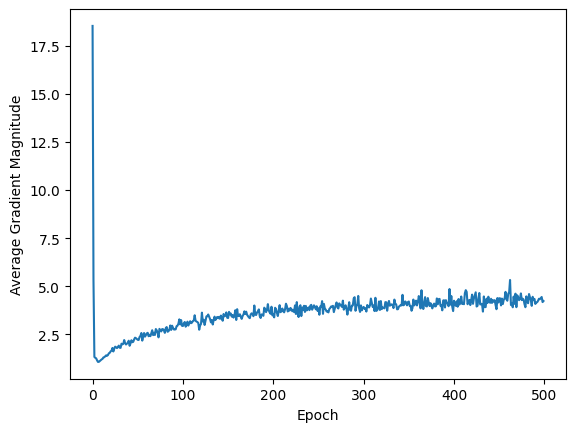

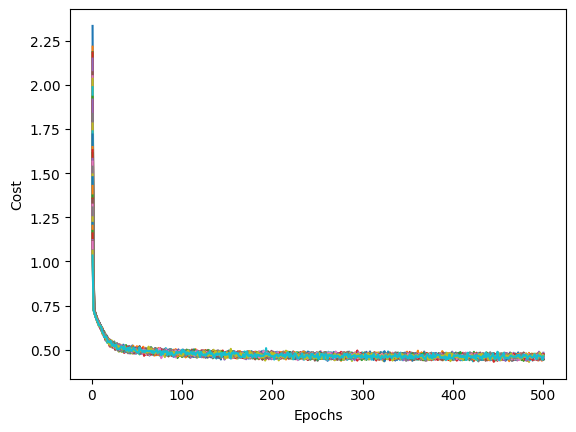

Accuracy: 0.7087458745874587


In [25]:

params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,'n_hidden_4':30,
         'C':0.1, 'epochs':500, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FiveLayerPerceptronAdam(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#### Adam Optimizer Performance

Using our layer five perceptron network with Adam, we obtained an accuract of 70.87%, which is a slight accuracy than the fifth layer perceptron of 70.45%, and the same as the RMSProp of 70.87%.

Because we ran over 500 Epochs, we noticed that both Adam and RMSProp achieved the same accuracy score of 70.87%. However, the Adam optimizer reaches the accuracy faster than the RMSProp, as shown below based on 50 Epochs where Adam with 50 epochs acheived a accuracy score of 69.41% and RMSProp with 50 epochs achieved an accuracy score of 69.26%.

Epoch: 1/50

Epoch: 50/50

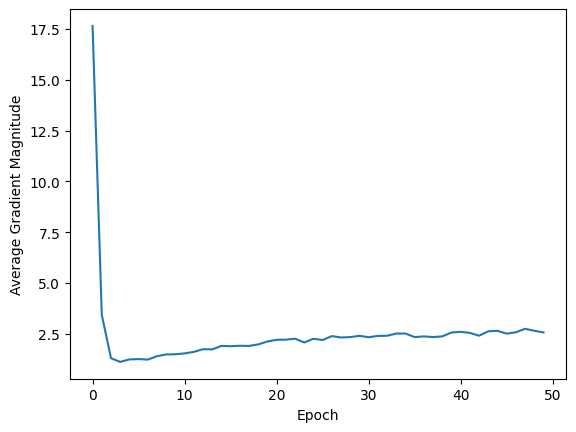

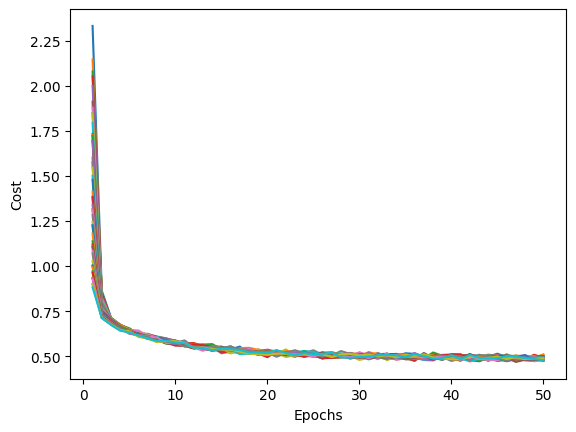

Accuracy: 0.6925880088008801


In [27]:
# RMSProp - 50 epochs
params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,'n_hidden_4':30,
         'C':0.1, 'epochs':50, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FiveLayerPerceptronRMSProp(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()

# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Epoch: 1/50

Epoch: 50/50

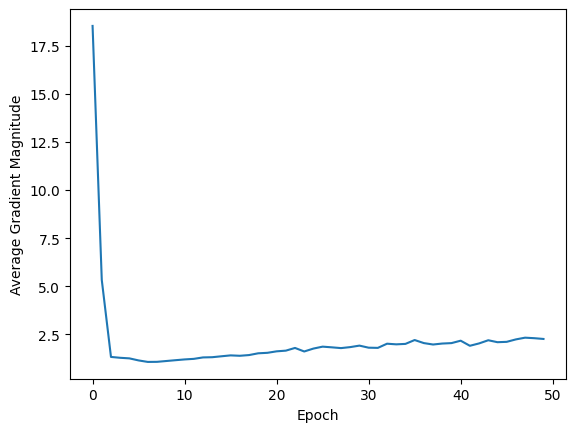

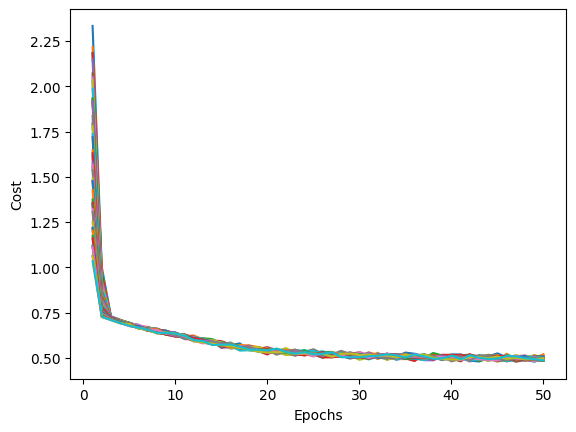

Accuracy: 0.6941006600660066


In [30]:

# Adam - Epoch 50 epochs
params = { 'n_hidden_1':30,'n_hidden_2':30, 'n_hidden_3':30,'n_hidden_4':30,
         'C':0.1, 'epochs':50, 'eta':0.001, 
         'alpha':0.001, 'decrease_const':1e-5, 'minibatches':50,
         'shuffle':True,'random_state':1}
# model = TLPVectorizedMiniBatchCrossEntropyGlorot(n_hidden=30, C=0.0, epochs=50, eta=0.001, random_state=42)
model = FiveLayerPerceptronAdam(**params)
model.fit(X_train, y_train, print_progress=True)
model.plot_grad_avg()
# plot the loss over time to ensure convergence
plt.plot(range(1, len(model.cost_)+1), model.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

# evaluate the model on the test set
y_pred = model.predict(X_test)

# convert y_pred into a one-hot encoded dataframe
y_pred = convert_data(y_pred)

# Get accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)